# Convex optimisation

The goal of this lab is to manipulate some of the convex optimisation tools from [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html), which you will need to implement the machine learning algorithms we will see in the course.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, set_matplotlib_formats 
set_matplotlib_formats('pdf', 'svg') # toggle vector graphics for a crisp plot!

## Introduction

Convex functions have the useful property that local minima are global minima.

To get a feel for scipy, we start with a simple example. We begin by defining a function to optimise, $$f_1(x) = (x - 1)^4 + x^2$$

In [2]:
# specify objective function
f1 = lambda x : (x - 1) ** 4 + x ** 2

We use Brent's method for optimisation. Brent's method does not require the function to optimize to be convex or derivable everywhere, and works as a combination of the secant method and parabola fittings, as follows:
1. Take a, b such that f'(a) < 0 and f'(b) > 0
2. Repeat:
  * Compute c = (a+b)/2
  * Compute the point d where the parabola that goes through a, b and c is minimal
  * If f'(d) < 10^{-sthg}: stop
  * Otherwise if f'(d) < 0: replace a with d, otherwise: replace b with d.
  
Illustration's source: Press, W. H., et al. (1992) "Numerical Recipes in Fortran, The Art of Scientific Computing", Cambridge University Press, Chapter 10.

In [3]:
from scipy.optimize import minimize_scalar

res = minimize_scalar(f1, method='brent')
print('xmin: %.02f, fval: %.02f, iter: %d' % (res.x, res.fun, res.nit))

xmin: 0.41, fval: 0.29, iter: 12


**Question:** Briefly describe the function output.

**Answer:** 
### The fucntion outputs the minimal(optimal) value of x (res.x) and its corresponding y-axis (res.fun). It also ouputs the number of iterations it took to get this minimal value of the function

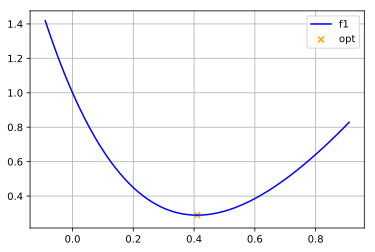

In [4]:
# plot curve
x = np.linspace(res.x - 0.5, res.x + 0.5, 100)
y = [f1(val) for val in x]
plt.plot(x, y, color='blue', label='f1')

# plot optima
plt.scatter(res.x, res.fun, color='orange', marker='x', label='opt')

plt.grid()
plt.legend(loc=1)

**N.B.** Optimisation, and particularly convex optimisation, plays a central role in machine learning. Although in this lab we focus on optimising simple functions, the same techniques will be used to optimise the high-dimensional loss functions of our learning machines.

#### Utility functions

In the following, we will be doing a lot of plotting, so we'll create a reusable function:

In [5]:
def plot_iterations(f, iterations, delta=0.1, box=1):
    xs = np.arange(-box, +box, delta)
    ys = np.arange(-box, +box, delta)
    X, Y = np.meshgrid(xs, ys)
    # create function mesh
    Z = np.array([[f(np.array([x, y])) for x in xs] for y in ys])
    # contour plot
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1)
    cd = ax.contour(X, Y, Z)
    # error plot
    ax.clabel(cd, inline=1, fontsize=10)
    ax.plot(iterations[:, 0], iterations[:, 1], color='red', marker='x', label='opt')
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(range(len(iterations)), [f(np.array(step)) for step in iterations], 'xb-')
    ax.grid('on')
    ax.set_xlabel('iteration')
    ax.set_xticks(range(len(iterations)))
    ax.set_ylabel('f(x)')

__Question:__ What does `plot_iterations` do?

__Answer:__
### It displays and mixed graph of the contour plot and error

We'll also need a callback function between iterations. This function will be called after each iteration.

In [6]:
# specify callback function
def get_callback_function(data_list):
    def callback_function(x):
        data_list.append(x)
    return callback_function

## Smooth functions

When our cost function is smooth, we can use the tools of calculus for an open or closed-formed solution. We here focus on the former case, where our function is optimised incrementally in an iterative procedure. In general, we iterate until the gradient of our function is close to zero. We again start by specifing a function to minimise,

\begin{align}
f_2(\mathbf{x}) &= 2x_1^2 + 5x_2^2 \\ \notag
&= \mathbf{x}^T\mathbf{D}\mathbf{x} \notag
\end{align}

where $\mathbf{D} = \begin{bmatrix}
    2 & 0 \\
    0 & 5 \end{bmatrix}$ and $\mathbf{x} \in \mathbb{R}^{2}$.

In [7]:

f2 =  lambda x: np.dot(x.T,np.dot(np.array([[2,0], [0, 5]]), x))


### Brute force search

First we'll try a trivial optimisation algorithm: [brute force](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brute.html#scipy.optimize.brute). A brute force search tries every point in a fixed grid and retains the minimising value.

In [8]:
from scipy.optimize import brute
print(brute(f2, ranges=((-2, 2), (-2, 2))))

[ 1.51252956e-05 -1.18367293e-07]


**Question:** Comment briefly on the output.

**Answer:**
### the optimum values of f2

### First and second-order characterizations

A twice-differentiable convex function has a positive semi-definite Hessian $\mathbf{x} \mapsto \nabla^2 f(\mathbf{x})$ and is minimized where the gradient $\mathbf{x} \mapsto \nabla f(\mathbf{x})$ is equal to 0.

**Question:** Write a function `df2()` for the Jacobian (vector of partial derivatives) of `f2()` below:

In [9]:
def df2(x):
    # TODO: return vector of partial derivatives
    return (np.array([[2,0], [0, 5]]) + np.array([[2,0], [0, 5]]).T).dot(x)
    
    

**Question:** Write a function `ddf2()` for the Hessian (matrix of second partial derivatives) of `f(2)` below:

In [10]:
def ddf2(x):
    return np.array([[4, 0], [0, 10]])


**Question:** Prove our Hessian matrix, $\mathbf{H} = \partial^2 f / \partial\mathbf{x}^2$, is positive-definite everywhere.

**Answer:** 
### calculating the eigen values gave only positive numbers

### Gradient descent methods

The workhorse of machine learning is gradient descent. Its variants are used to optimise a panoply of models from linear regression to deep neural nets. The gradient of mulivariate function at a point is the vector normal to the level curve. Gradient descent works by taking steps in the direction of the gradient,

$$\mathbf{x}_{k+1} = \mathbf{x}_{k} -\alpha\nabla f(\mathbf{x_k})$$

#### Newton's Method

Newton's method is a second order method, minimising a quadratic Taylor approximation to the objective function at each point. It thus combines the gradient and Hessian matrix,

$$\mathbf{x}_{k+1} = \mathbf{x}_{k} -\alpha\mathbf{H}_k^{-1}\mathbf{g}_k$$

where $\mathbf{g}_k = \nabla f(\mathbf{x_k})$ and $\mathbf{H}_k = \nabla^2 f(\mathbf{x_k})$. This is a multi-dimensional generalisation of the Newton root-finding method (here we are finding the root of the gradient). Newton's method typically involves a line search to optimise the size of the descent step, $\alpha$.

**Question:** Fill in the missing lines in the cell below to run [Newton's method](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fmin_ncg.html) on our function. Note, in this implementation, the (sparse) Hessian is inverted by conjugate gradient descent.

In [11]:
# import 
# TODO
from scipy.optimize import fmin_ncg


# specify initial point
x0 = [-1, 1]
# initialise callback data
ncg_data = [np.array(x0)]

# use fmin_ncg
# TODO
using_min = fmin_ncg(f2, x0, df2, fhess=ddf2, callback=get_callback_function(ncg_data))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 14
         Hessian evaluations: 7


/usr/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


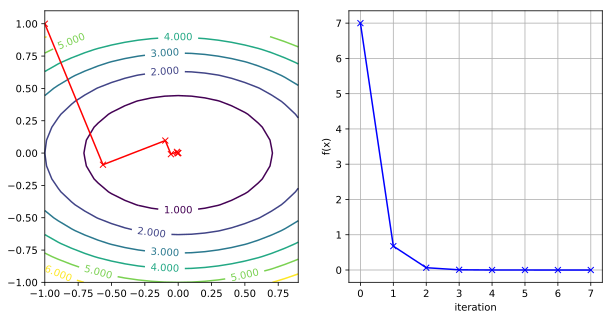

In [12]:
plot_iterations(f2, np.array(ncg_data))

**Question:** Newton's method uses a line search to optimise each descent step by choosing a step size $\alpha$ that optimises the descent direction, that is, $$\min_\alpha f(\mathbf{x_k} + \alpha \mathbf{d}_k),$$ where $\mathbf{d}_k = \nabla f({\mathbf{x}_k})$ is the descent direction. How does this show in the visualisation?

**Answer:**
### they are all perpendicular according to the plot.

#### Quasi-Newton: BFGS

[Broyden–Fletcher–Goldfarb–Shanno (BFGS)](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) is a quasi-Newton method. Because the Hessian is $\mathcal{O}(n^2)$ (a large expense at each iteration), BFGS aims to approximate the Hessian "on the fly" as a sum of rank one approximations. Note when space *and* runtime are a concern, *limited-memory* BFGS (l-BFGS) is further an option.

**Question:** Run the [scipy BFGS](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_bfgs.html#scipy.optimize.fmin_bfgs) algorithm on our function.

In [21]:
# import 
# TODO
from scipy.optimize import fmin_cg

# initialise callback data
x0 = [-1,1]
call_bck_data = [np.array(x0)]

# use fmin_ncg
# TODO

using_min = fmin_cg(f2, x0, df2, callback=get_callback_function(call_bck_data))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6


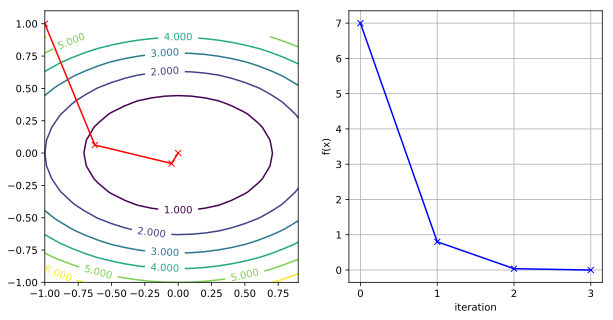

In [22]:
# Plot the iterations
# TODO 
plot_iterations(f2, np.array(call_bck_data))

**Question:** Verify that the norm of the gradient at the final point is close to 0.

In [23]:
# TODO calculate the norm of the gradient
norm = np.sqrt(np.dot(df2(using_min), df2(using_min)))
norm

4.996003610813204e-16

**Question:** What do you observe about the steps?

**Answer:** 
### they are all perpendicular according to the plot.

#### Conjugate gradient method

The [conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method) is an alternative to gradient descent. For a linear system $\mathbf{A}\mathbf{x} = \mathbf{b}$, this algorithm finds a solution as a linear combination of a set of *mutually conjugate vectors*, $\mathbf{p}_d$, such that,

$$\mathbf{x}^* = \sum_{d=1}^D \alpha_d\mathbf{p}_d$$ for the $D$ dimensions of the problem. The vectors are built determined one by one in a process similar to the [Gram Schmidt process](https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process). Particularly for a sparse system, a good approximate solution can be determined without constructing the entire conjugate set.

__Question:__ Run the conjugate gradient method `fmin_cg` on our function.

In [24]:
# initialise callback data
cg_data = [np.array([-1,1])]

# TODO
res = fmin_cg(f2, [-1,1], df2, callback=get_callback_function(cg_data))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6


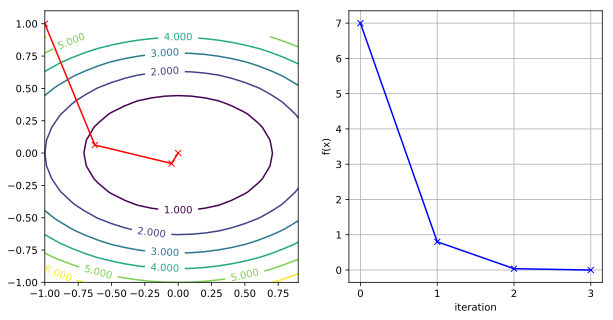

In [25]:
# Plot the iterations
# TODO
plot_iterations(f2, np.array(cg_data))

**Question:** Try changing the initial point. Does anything change? Why?

**Answer:** 
### Nothing changed

# Bonus Question

## Non-smooth functions

Convex functions remain convex when we add linear constraints. A linear constraint restricts the solution space with an intersecting hyperplane. However, the smoothness property is lost, and calculus is no longer an option. To conceptualise the effect, imagine taking a spherical fruit such as an apple to be our unconstrained convex function. Then, adding a linear constraint corresponds to slicing it at some position at a fixed angle. Intuitively, the fruit remains convex after the cut, despite losing its smoothness (roundness).

#### Quadratic programming

A [quadratic programming (QP) problem](https://en.wikipedia.org/wiki/Quadratic_programming) is an optimisation problem of a quadratic function $\frac{1}{2}\mathbf{x^TQx} + \mathbf{c^Tx}$ subject to linear constraints, $\mathbf{Ax} \leq \mathbf{b}$. QP optimisation algorithms can be applied to the training of support vector machines (SVMs). Let's optimise the following quadratic program:

$$
\begin{array}{rl}
\text{minimise} & z = x_1^2 + 4x_2^2 - 32x_2 + 64 \\
\text{subject to} & x_1 + x_2 \leq 7 \\
& -x_1 + 2x_2 \leq 4 \\
& x_2 \leq 4 \\
& x_1, x_2 \geq 0
\end{array},
$$



**Question:** Specify the constraint matrices, $\mathbf{A}$ (coefficients), and $\mathbf{b}$ (constants).

In [26]:
# specify the matrix of coefficients
A = np.array([[ 1., 1.],
              [-1., 2.],
              [0.,  1.],
              [-1., 0.],
              [0., -1.]])

# TODO: specify the vector of constants, B
b = np.array([7., 4., 4., 0., 0.])

We create dictionary of constraints for use in the optimisation function:

In [27]:
cons = {'type':'ineq',
        'fun':lambda x: b - np.dot(A,x),
        'jac':lambda x: -A}

**Question:** Next, specify the components of the objective function: the matrix of quadratic coefficients $\mathbf{Q}$, the vector of linear coefficients $\mathbf{c}$, and the constant term, $c_0$.

In [31]:
# specify the matrix of quadratic coefficients
Q = np.array([[2., 0.], [0., 8.]])

# specify the vector of linear coefficients
c = np.array([0, -32])

# specify the constant
c0 = 64

**Question:** Write the objective function (loss).

In [34]:
def loss(x):
    # TODO: return loss (= objective function) given x
    return 0.5 * np.dot(x.T, np.dot(Q, x)) + np.dot(c, x) + c0


**Question:** Write the Jacobian function.

In [35]:
def jac(x):
    # TODO: return vector of partial derivatives
    return np.dot(x.T, Q) + c


**Question:** Run scipy.optimize's minimize function on our QP problem.

In [36]:
from scipy.optimize import minimize

x0 = np.random.randn(2)
opt = {'disp':False}
res_cons = minimize(loss, x0, jac=jac, constraints=cons, method='SLSQP', options=opt)

print('\nConstrained:')
print(res_cons)

x1, x2 = res_cons['x']
f = res_cons['fun']


Constrained:
     fun: 7.999999999999176
     jac: array([ 4., -8.])
 message: 'Optimization terminated successfully.'
    nfev: 4
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([2., 3.])


Finally, we will plot the solution in 3D axes. Feel free to change the code to adjust the view.

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  


Text(0.5,0,'F')

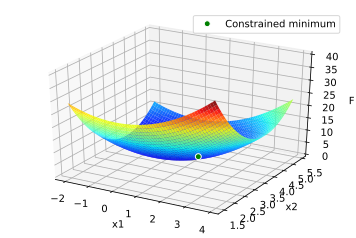

In [37]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
# plotting
xgrid = np.mgrid[-2:4:0.1, 1.5:5.5:0.1]
xvec = xgrid.reshape(2, -1).T
F = np.vstack([loss(xi) for xi in xvec]).reshape(xgrid.shape[1:])

ax = plt.axes(projection='3d')
ax.hold(True)
ax.plot_surface(xgrid[0], xgrid[1], F, rstride=1, cstride=1,
                cmap=plt.cm.jet, shade=True, alpha=0.9, linewidth=0)
ax.plot3D([x1], [x2], [f], 'og', mec='w', label='Constrained minimum')
ax.legend(fancybox=True, numpoints=1)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('F')